## Neural Network Model Building in H2O

I will go through 2 H2O  models including  GBM, and DL (Deep Learning NN).

I'll use H2OFlow for the hyperparameters searching (it's just easier than writing code) and post here the best parameters found.


# H2O

In [1]:
import pandas as pd
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
import h2o
import time
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [4]:
# Connect to a cluster
h2o.init()

Connecting to H2O server at http://localhost:54321... successful!


/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.0.4
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_nobody_1izwnh
H2O cluster total nodes:,1
H2O cluster free memory:,24.48 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster is healthy:,True
H2O cluster is locked:,False
H2O connection url:,http://localhost:54321


In [5]:
#Let's define variables that will define the behaviour of the whole script
path = './input-data/'
use_validation=True # splits train data into train + val sets
val_week_threshold = 9 # (possible values 8 or 9)  - weeks 3,4,5,6,7 are train, and week 8.9 are val
trimmed = True # removes weeks which doesn't have all the lags. If False, fills empty lags with 0
lag = 5  # shifted mean_demand up to "lag" weeks
if (val_week_threshold == 8): lag = 4

In [6]:
#now we load our modified train and test set
tic()
sufix=""
sufix=""
if (use_validation): 
    sufix += "_holdout"
    sufix += repr(val_week_threshold)
if (trimmed): sufix += "_trimmed"

train_csv = path +"train_modified"+sufix+".csv"
val_csv = path +"val_modified"+sufix+".csv"
test_csv = path +"test_modified"+sufix+".csv"

tic()
print ('Downloading File: {} ...'.format(train_csv))
train = h2o.import_file(train_csv)

if (use_validation):
    print ('Downloading File: {} ...'.format(val_csv))
    val = h2o.import_file(val_csv)
    
print ('Downloading File: {} ...'.format(test_csv))
test = h2o.import_file(test_csv)
tac()




Time passed: 0hour:0min:18sec


In [7]:
train.show()

Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Log_Target_mean_lag5,Lags_sum,brand,prodtype_cluster,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID,Qty_Ruta_SAK_Bin
8,1110,7,3301,15766,1212,1.60944,0.187761,0,0,0.210489,0.190189,1.38629,0.117228,1,18,2008,0,11,21,41,5,54,1
8,1110,7,3301,15766,1216,1.79176,0.150239,0.128994,0.0813821,0.162856,0.129824,1.60944,0.144129,1,2,2008,0,11,21,41,5,54,1
8,1110,7,3301,15766,1220,0.693147,0.12207,0,0,0.162856,0,0,0.0339453,1,8,2008,0,11,21,41,5,54,1
8,1110,7,3301,15766,1238,1.38629,0.142305,0.128994,0.128988,0.0814281,0.16382,1.60944,0.144129,1,2,2008,0,11,21,41,5,54,1
8,1110,7,3301,15766,1240,1.09861,0.205013,0.257987,0,0,0.24573,1.60944,0.144129,1,14,2008,0,11,39,41,5,54,1
8,1110,7,3301,15766,1242,0.693147,0.137938,0.128994,0.162764,0.129061,0.16382,1.38629,0.155638,1,25,2008,0,11,5,41,5,54,1
8,1110,7,3301,15766,1250,2.19722,0.214731,0.317966,0.0813821,0.258121,0.16382,1.79176,0.214904,1,25,2008,0,11,14,41,5,54,1
8,1110,7,3301,15766,1309,1.38629,0.196962,0.270358,0.228468,0.228598,0.129824,1.38629,0.212525,1,18,2008,0,11,29,41,5,54,1
8,1110,7,3301,15766,3894,1.09861,0.206246,0.188972,0.188963,0.258121,0.24573,1.94591,0.231187,13,18,2008,0,11,0,41,5,54,1
8,1110,7,3301,15766,30531,2.89037,0.286383,0.309865,0.30115,0.281695,0.22995,2.19722,0.287593,13,12,2008,0,11,11,41,5,54,1


In [8]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [9]:
# H2O python API recently (Jun 2016) added RSME as a model performance metric. So we are going to use it directly
# into our target = log_target , to get the RSMLE

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):   
    #Fit the algorithm on the data
    alg.train(x=predictors, y=target, training_frame=dtrain, validation_frame=dval)
    
    #Performance on Training and Val sets:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', alg.model_performance(train).rmse())
    print ('RMSLE VAL: ', alg.model_performance(val).rmse())
 
    #Predict on testing data: we need to revert it back to "Demanda_uni_equil" by applying expm1 
    dtest[target] = alg.predict(dtest[predictors]).expm1()
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    
    #Export submission file:
    submission = dtest[[IDcol,target]].as_data_frame(use_pandas=True)
    submission[target] = np.maximum(submission[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)

Let's define now the target and the Id cols

In [10]:
#H@O would automatically hot-encode the categorical values (Genius!), but we must specify what columns are categoricals
train['brand'] = train['brand'].asfactor()
train['prodtype_cluster'] = train['prodtype_cluster'].asfactor()
train['ZipCode'] = train['ZipCode'].asfactor()
train['week_ct'] = train['week_ct'].asfactor()
train['NombreCliente'] = train['NombreCliente'].asfactor()
train['Producto_ID_clust_ID'] = train['Producto_ID_clust_ID'].asfactor()
train['Ruta_SAK_clust_ID'] = train['Ruta_SAK_clust_ID'].asfactor()
train['Agencia_ID_clust_ID'] = train['Agencia_ID_clust_ID'].asfactor()
train['Cliente_ID_clust_ID'] = train['Cliente_ID_clust_ID'].asfactor()


In [11]:
# In case there is no validation, we make val = train
if not (use_validation):
    val = train

### Alg8 - GBM

Lets make our first GBM model



Model Report
RMSLE TRAIN:  0.44344258986051704
RMSLE VAL:  0.47198108164300834

NUM ROWS PREDICTED:  6999251
MIN TARGET PREDICTED:  -0.2581275253092238
MEAN TARGET PREDICTED:  [5.914859023629326]
MAX TARGET PREDICTED:  3023.2683140171703
Time passed: 0hour:22min:55sec


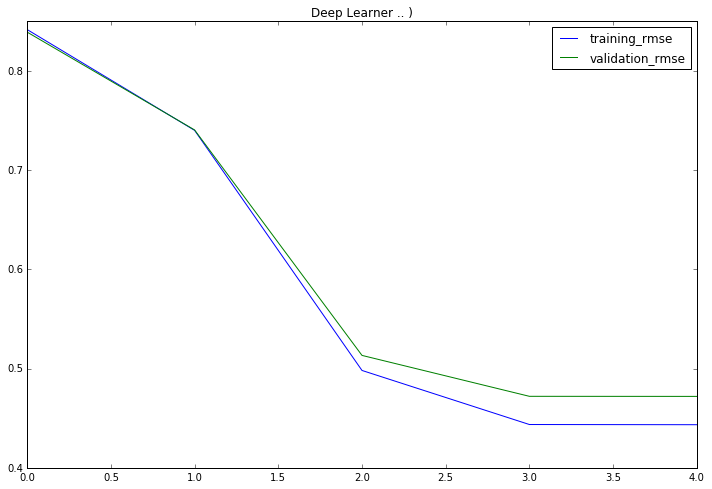

In [12]:
#predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
#              'Agencia_ID','Ruta_SAK','Cliente_ID','Producto_ID',
#              'Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']

predictors = [x for x in train.columns if x not in [target]+[IDcol]]
predictors.remove('pairs_mean')
predictors.remove('Log_Target_mean_lag1')
predictors.remove('Lags_sum')

model = H2OGradientBoostingEstimator(ntrees=500,max_depth=10,learn_rate=0.1, min_rows=10, nbins=40, sample_rate=0.7,
                                    col_sample_rate=0.7, stopping_rounds=10, stopping_metric="MSE", stopping_tolerance=0.001)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg8_{}.csv'.format(sufix))
tac()

model.varimp(use_pandas=True)

#Plot Histogram of target and prediction distributions
model_history_df = model.scoring_history()
model_history_df
plt.plot(model_history_df['training_rmse'], label="training_rmse")
plt.plot(model_history_df['validation_rmse'], label="validation_rmse")
plt.title("GBM Training History")
plt.legend();

## --> LB: 

### Alg9 - Deep Learning

Now we try with a Deep Learning Network. To improve generalization we added dropout and L1 and L2 penalties.



Model Report
RMSLE TRAIN:  0.5497529644430854
RMSLE VAL:  0.5543146584761919

NUM ROWS PREDICTED:  6999251
MIN TARGET PREDICTED:  1.0357010837705247
MEAN TARGET PREDICTED:  [5.185888029306628]
MAX TARGET PREDICTED:  1840.8869296685314
Time passed: 0hour:52min:0sec


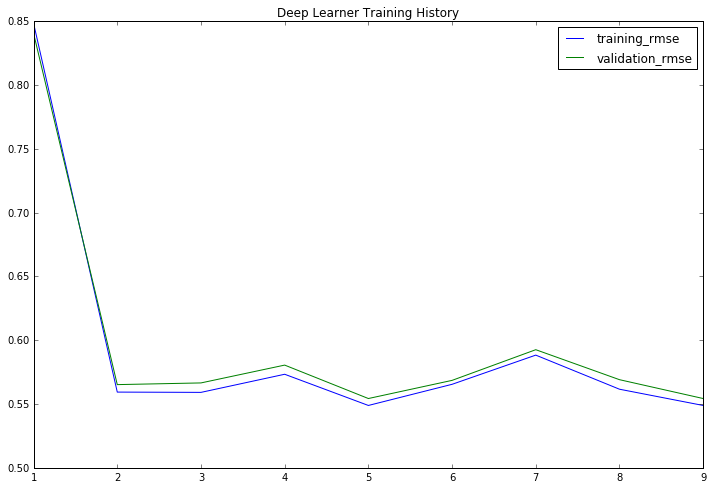

In [18]:
predictors = ['Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 'Log_Target_mean_lag5',
              'Agencia_ID','Ruta_SAK','Lags_sum', 
              'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']



model = H2ODeepLearningEstimator(activation="Rectifier", hidden=[100,100,100], epochs=35, input_dropout_ratio=0.1,
                                standardize=False, score_interval=10, stopping_rounds=10, stopping_metric="MSE",
                                stopping_tolerance=0.001)
    
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg9_{}.csv'.format(sufix))
tac()

model.varimp(use_pandas=True)

#Plot Histogram of target and prediction distributions
model_history_df = model.scoring_history()
model_history_df
plt.plot(model_history_df['training_rmse'], label="training_rmse")
plt.plot(model_history_df['validation_rmse'], label="validation_rmse")
plt.title("Deep Learner Training History")
plt.legend();